In [223]:
from ignite.contrib.metrics.regression import *
from ignite.contrib.metrics import *
from ignite.handlers import *
from ignite.metrics import *
from ignite.engine import *
from ignite.utils import *

from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn.functional as F
import data.read_samples as rs
import torch.optim as optim
import torch.utils.data
import torch.nn as nn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import OrderedDict
from scipy import io

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import torch
import time
import os
import gc

print(datetime.datetime.now(), "model.py code start")

BATCH_SIZE = 107
EPOCH = 400
LEARNING_RATE = 0.2
ANNEALING_RATE = 0.999
HIDDEN_UNITS = [180, 200, 250, 80, 100, 120]
K_FOLD = 1
MAT_PATH = "C:/Users/HILAB_Labtop_02/Desktop/insung/ecg-dbn/data/mit.mat"

2022-05-26 00:37:42.177071 model.py code start


In [224]:
device = torch.device('cuda')
print(torch.cuda.get_device_name(device))
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

NVIDIA GeForce RTX 3080 Laptop GPU


In [225]:
class RBM(nn.Module): 
    with torch.cuda.device(0):
        def __init__(self, n_vis, n_hid, k, batch):
            super(RBM, self).__init__()
            self.W      = nn.Parameter(torch.randn(1, batch, device=device) * 1e-2)
            self.n_vis  = n_vis
            self.n_hid  = n_hid
            self.k      = k
            self.batch  = batch
            self.v_bias = nn.Parameter(torch.zeros(n_vis, 1, device=device))
            self.h_bias = nn.Parameter(torch.zeros(n_hid, 1, device=device))
        
        def sample_from_p(self, p):
            return F.relu(
                torch.sign(
                    p - Variable(torch.randn(p.size(), device=device))
                )
            ).to(device=device)

        ''' ISSUE PART '''
        def v_to_h(self, v):
            w = (self.W.clone())

            p_h = F.sigmoid(
                F.linear(v, w)
            ).to(device=device)

            sample_h = self.sample_from_p(p_h)
            return p_h, sample_h

        def h_to_v(self, h):
            w = self.W.t().clone()

            p_v = F.sigmoid(
                F.linear(h, w)
            ).to(device=device)

            sample_v = self.sample_from_p(p_v)
            return p_v, sample_v
        
        def forward(self, v):
            pre_h1, h1 = self.v_to_h(v)
            h_ = h1

            for _ in range(self.k):
                pre_v_, v_ = self.h_to_v(h_)
                pre_h_, h_ = self.v_to_h(v_)
            return v, v_
        
        def get_weight(self):
            return self.W

In [226]:
class SVM(nn.Module):
    with torch.cuda.device(0):
        def __init__(self, lr, n_x):
            super(SVM, self).__init__()
            self.lr = lr
            self.fully = nn.Linear(n_x, 1).to(device=device)
        
        def forward(self, x):
            fwd = self.fully(x)
            return fwd

In [227]:
def to_categorical(y, num_classes):
    return np.eye(num_classes, dtype='uint8')[y]

In [213]:
mit = io.loadmat(MAT_PATH)
mit = mit['mit']
df_mit = pd.DataFrame(data = mit)

print(df_mit[428].value_counts(), '\n')
# 0 = N
# 1 = Q
# 2 = S
# 3 = V
# 4 = F

Y = np.array(df_mit[428].values).astype(np.int8)
X = np.array(df_mit[list(range(428))].values)[..., np.newaxis]

oneHot = LabelEncoder()
oneHot.fit(Y)
Y = oneHot.transform(Y)

X = X.reshape(-1, 428, 1)
Y = to_categorical(Y, 5)

X_train, X_val, Y_train, Y_val = train_test_split(X, Y,
                                                test_size=0.3,
                                                random_state=42,
                                                stratify=Y)

print("X_train shape: ", X_train.shape)
print("Y_train shape: ", Y_train.shape)
print("X_val shape: ", X_val.shape)
print("Y_val shape: ", Y_val.shape)

0.0    89921
3.0     6999
2.0     2777
4.0      801
1.0       15
Name: 428, dtype: int64 

X_train shape:  (70359, 428, 1)
Y_train shape:  (70359, 5)
X_val shape:  (30154, 428, 1)
Y_val shape:  (30154, 5)


In [214]:
train_dataloader = DataLoader(X_train,
                              batch_size=BATCH_SIZE,
                              num_workers=0,
                              shuffle=True)

test_dataloader = DataLoader(X_val,
                             batch_size=BATCH_SIZE,
                             num_workers=0,
                             shuffle=True)

In [215]:
def eval_step(engine, batch):
    return batch

default_model = nn.Sequential(OrderedDict([
    ('base', nn.Linear(4, 2)),
    ('fc', nn.Linear(2, 1))
]))

default_evaluator = Engine(eval_step)

def get_acc(y_true, y_pred):
    metric = Accuracy()
    metric.attach(default_evaluator, "accuracy")
    state = default_evaluator.run([[y_pred, y_true]])
    return state.metrics["accuracy"]

In [216]:
bbrbm_first = RBM(n_vis=187, n_hid=HIDDEN_UNITS[0], k=K_FOLD, batch=BATCH_SIZE).to(device=device)
bbrbm_second = RBM(n_vis=187, n_hid=HIDDEN_UNITS[1], k=K_FOLD, batch=BATCH_SIZE).to(device=device)
bbrbm_third = RBM(n_vis=187, n_hid=HIDDEN_UNITS[2], k=K_FOLD, batch=BATCH_SIZE).to(device=device)

gbrbm_first = RBM(n_vis=187, n_hid=HIDDEN_UNITS[3], k=K_FOLD, batch=BATCH_SIZE).to(device=device)
gbrbm_second = RBM(n_vis=187, n_hid=HIDDEN_UNITS[4], k=K_FOLD, batch=BATCH_SIZE).to(device=device)
gbrbm_third = RBM(n_vis=187, n_hid=HIDDEN_UNITS[5], k=K_FOLD, batch=BATCH_SIZE).to(device=device)

first_train_op = optim.Adagrad(bbrbm_first.parameters(), LEARNING_RATE)
second_train_op = optim.Adagrad(bbrbm_second.parameters(), LEARNING_RATE)
third_train_op = optim.Adagrad(bbrbm_third.parameters(), LEARNING_RATE)

gb_first_train_op = optim.Adagrad(gbrbm_first.parameters(), LEARNING_RATE)
gb_second_train_op = optim.Adagrad(gbrbm_second.parameters(), LEARNING_RATE)
gb_third_train_op = optim.Adagrad(gbrbm_third.parameters(), LEARNING_RATE)

omse_loss = list()
output_gb = list()
best_acc = float()
svm_best_acc = float()
mse_loss = nn.MSELoss()

# gaussian_std = torch.arange(1, 0, -0.00537, device=device)
gaussian_std = torch.arange(1, 0, -0.0094, device=device)
print(gaussian_std.size())

svm_model = SVM(lr=LEARNING_RATE, n_x=107)
svm_optimizer = optim.Adagrad(svm_model.parameters(), lr=LEARNING_RATE)

torch.Size([107])


In [217]:
LOAD_PATH = "./say_cheese/ahh_saveMode_through_107_80.37383177570094GBRBM.pth"

load_model = RBM(n_vis=187, n_hid=120, k=K_FOLD, batch=BATCH_SIZE)
load_model.load_state_dict((torch.load(LOAD_PATH)))
load_model.to(device=device)

for i, (data) in enumerate(test_dataloader):
    if i == 939:
        continue

    data = Variable(
            torch.tensor(data, dtype=torch.float32)
    ).uniform_(0, 1)
    
    sample_data = torch.bernoulli(data).view(-1, 107).to(device=device)
    
    # tensor binary
    vog_first, v1 = load_model(sample_data)
    omse_loss = mse_loss(vog_first, v1)
    
    first_train_op.zero_grad()
    first_train_op.step()
    omse_loss.backward()

print("Load model: ", LOAD_PATH)
print("Acc : ", get_acc(vog_first, v1))

C:\Users\HILAB_~1\AppData\Local\Temp/ipykernel_6104/2187820300.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(data, dtype=torch.float32)
c:\Users\HILAB_Labtop_02\anaconda3\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Load model:  ./say_cheese/ahh_saveMode_through_107_80.37383177570094GBRBM.pth
Acc :  0.5023901600601568


In [218]:
SVM_LOAD_PATH = "./mat_svm_model/7_Train_svm_model_acc__.pth"

svm_model_load = SVM(lr=LEARNING_RATE, n_x=143)
svm_model_load.load_state_dict(torch.load(SVM_LOAD_PATH))
svm_model_load.to(device=device)


SVM(
  (fully): Linear(in_features=143, out_features=1, bias=True)
)

In [219]:
svm_X = torch.tensor(v1, dtype=torch.float32, device=device)
svm_Y = torch.tensor(Y, dtype=torch.float32, device=device)
N = len(svm_Y)

# model predict
for i in range(0, N, BATCH_SIZE):
        correct = float()

        x = torch.tensor(svm_X.clone().detach(), device=device)
        y = torch.tensor(svm_Y.clone().detach(), device=device)

        # Forward
        output = svm_model(x)
        
        # Backward
        svm_optimizer.zero_grad()        
        svm_optimizer.step()

        predicted = torch.tensor(output.data >= 0, dtype=torch.float32)
        svm_acc = (output.data >= predicted).int()
        
print("SVM Model Predicted: ", predicted.sum() / predicted.size()[0], "Accuracy: ", svm_acc.sum())

C:\Users\HILAB_~1\AppData\Local\Temp/ipykernel_6104/474829753.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  svm_X = torch.tensor(v1, dtype=torch.float32, device=device)
C:\Users\HILAB_~1\AppData\Local\Temp/ipykernel_6104/474829753.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(svm_X.clone().detach(), device=device)
C:\Users\HILAB_~1\AppData\Local\Temp/ipykernel_6104/474829753.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(svm_Y.clone().detach(), device=device)
C:\Users\HILAB_~1\AppData\Lo

SVM Model Predicted:  tensor(0.0115, device='cuda:0') Accuracy:  tensor(0, device='cuda:0')


In [220]:
print(torch.flatten(predicted, end_dim=1))


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

In [234]:
new_y = []
# for val in np.array(torch.tensor(Y[:348]).unsqueeze(1)):
for val in output.data:
    max = 0
    cnt = 0
    for idx, num in enumerate(val):
        if max < num.any():
            max = num
            cnt = idx + 1
    new_y.append(cnt)
print(len(new_y))

348


In [235]:
new_y_pred = []
for val in predicted:
    max = 0
    cnt = 0
    for idx, num in enumerate(val):
        if max < num:
            max = num
            cnt = idx + 1
    new_y_pred.append(cnt)

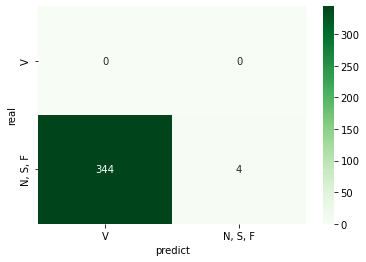

In [236]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

cm2 = confusion_matrix(new_y, new_y_pred)
sns.heatmap(cm2, annot = True, fmt = 'd', cmap= 'Greens')
plt.xlabel('predict')
plt.ylabel('real')
plt.xticks([0.5, 1.5], ['V', 'N, S, F'])
plt.yticks([0.5, 1.5], ['V', 'N, S, F'])
plt.show()

In [229]:
confusion_matrix(new_y, new_y_pred)

array([[  0,   0],
       [344,   4]], dtype=int64)